In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





In [4]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
batch_size_cuda = 32
batch_size_cpu = 32

dataloader_args = dict(shuffle=True, batch_size=batch_size_cuda, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size_cpu)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([32, 1, 28, 28])
torch.Size([32])


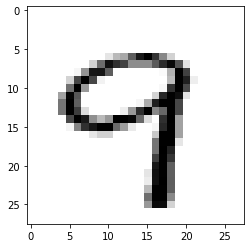

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

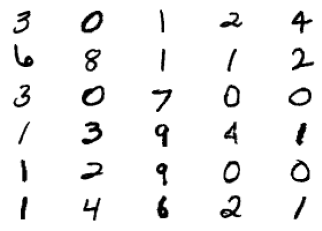

In [7]:
figure = plt.figure()
num_of_images = 30
for index in range(1, num_of_images + 1):
    plt.subplot(6, 5, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # In: 28x28x1 | Out: 26x26x16 | RF: 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # In: 26x26x16 | Out: 24x24x16 | RF: 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        ) # In: 24x24x16 | Out: 22x22x16 | RF: 7

         # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # In: 22x22x12 | Out: 11x11x12 | RF: 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # In: 11x11x16 | Out: 9x9x16 | RF: 12

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # In: 9x9x16 | Out: 7x7x16 | RF: 16
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # In: 7x7x16 | Out: 5x5x16 | RF: 20

        # OUTPUT BLOCK
        #self.gap = nn.Sequential(
        #    nn.AdaptiveAvgPool2d(output_size=1)
       # ) In: 5x5x16 | Out: 1x1x16 | RF: 28
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(5, 5), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # In: 1x1x16 | Out: 1x1x10 | RF: 32


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        #x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           2,304
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           2,304
         MaxPool2d-6           [-1, 16, 11, 11]               0
            Conv2d-7             [-1, 16, 9, 9]           2,304
              ReLU-8             [-1, 16, 9, 9]               0
            Conv2d-9             [-1, 16, 7, 7]           2,304
             ReLU-10             [-1, 16, 7, 7]               0
           Conv2d-11             [-1, 16, 5, 5]           2,304
             ReLU-12             [-1, 16, 5, 5]               0
           Conv2d-13             [-1, 10, 1, 1]           4,000
Total params: 15,664
Trainable para

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 5
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Loss=2.3023173809051514 Batch_id=3 Accuracy=10.16:   0%|          | 2/1875 [00:00<01:36, 19.45it/s]

EPOCH: 1


Loss=0.13286325335502625 Batch_id=1874 Accuracy=89.33: 100%|██████████| 1875/1875 [01:10<00:00, 26.50it/s]
Loss=0.30113208293914795 Batch_id=3 Accuracy=96.88:   0%|          | 3/1875 [00:00<01:23, 22.45it/s]


Test set: Average loss: 0.0882, Accuracy: 9725/10000 (97.25%)

EPOCH: 2


Loss=0.2625475525856018 Batch_id=1874 Accuracy=97.90: 100%|██████████| 1875/1875 [01:17<00:00, 24.15it/s]
Loss=0.08647969365119934 Batch_id=3 Accuracy=99.22:   0%|          | 3/1875 [00:00<01:18, 23.83it/s] 


Test set: Average loss: 0.0577, Accuracy: 9827/10000 (98.27%)

EPOCH: 3


Loss=0.1467067003250122 Batch_id=1874 Accuracy=98.53: 100%|██████████| 1875/1875 [01:16<00:00, 24.42it/s]
Loss=0.2186429798603058 Batch_id=3 Accuracy=98.44:   0%|          | 3/1875 [00:00<01:15, 24.76it/s]  


Test set: Average loss: 0.0443, Accuracy: 9863/10000 (98.63%)

EPOCH: 4


Loss=0.0018534425180405378 Batch_id=1874 Accuracy=98.70: 100%|██████████| 1875/1875 [01:17<00:00, 24.07it/s]
Loss=0.005810941569507122 Batch_id=3 Accuracy=100.00:   0%|          | 3/1875 [00:00<01:20, 23.36it/s]


Test set: Average loss: 0.0342, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.1723022758960724 Batch_id=1874 Accuracy=98.97: 100%|██████████| 1875/1875 [01:15<00:00, 24.82it/s]



Test set: Average loss: 0.0390, Accuracy: 9876/10000 (98.76%)

